In [2]:
import argparse

import math
import sys, platform, os
from numpy.linalg import inv
from scipy.integrate import quad
from matplotlib import pyplot as plt
import numpy as np

font = {'size' : 14, 'family' : 'serif', 'serif' : 'cm'}
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

params = {'legend.fontsize': 12}
plt.rcParams.update(params)

In [3]:
# redshift bin edges
zlist = np.array([0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.6, 1.8, 2., 2.3, 2.6, 3., 3.5, 4., 7.])

In [5]:
# Load FoM results

# kmax = 0.3 h/Mpc
kmax_p3 = np.loadtxt("kgTE_N16_test.dat")
# kmax = 0.15 h/Mpc
kmax_p15 = np.loadtxt("kgTE_N16_k15.dat")

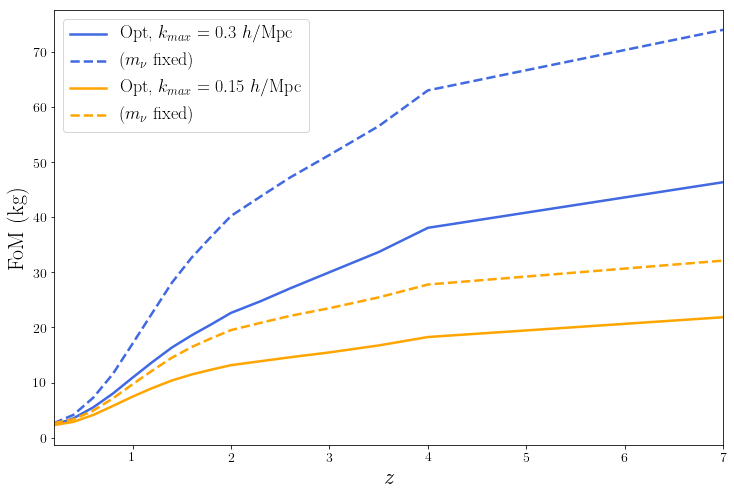

In [13]:
# FoM vs z.
plt.figure(figsize = (12,8))
plt.plot(zlist, kmax_p3[:,3], linewidth = 2.5, color = 'royalblue', label = 'Opt, $k_{max} = 0.3\ h/$Mpc')
plt.plot(zlist, kmax_p3[:,6], '--', linewidth = 2.5, color = 'royalblue', label = '($m_{\\nu}$ fixed)')

plt.plot(zlist, kmax_p15[:,3], linewidth = 2.5, color = 'orange', label = 'Opt, $k_{max} = 0.15\ h/$Mpc')
plt.plot(zlist, kmax_p15[:,6], '--', linewidth = 2.5, color = 'orange', label = '($m_{\\nu}$ fixed)')

plt.ylabel('FoM (kg)', fontsize = 22)
plt.xlabel('$z$', fontsize = 22)
plt.legend(fontsize = 18)
plt.xlim(0.2, 7)
plt.show()

In [14]:
from orphics.stats import FisherMatrix

In [19]:
# S4 Fisher
params = []
params.append('H0')
params.append('ombh2')
params.append('omch2')
params.append('ns')
params.append('As')
params.append('mnu')
params.append('w')
params.append('tau')
params.append('wa')
FisherS4 = np.loadtxt('ppf_S4_nophi.txt')
FisherS4 = FisherMatrix( FisherS4, params )

# Optimisti kg Fisher
FisherM = np.loadtxt("Fisher_ppf_N16.dat")

N = 16
params = []

for i in range(N):
    params.append('sig8_%s' %i)

for i in range(N):
    params.append('b1_%s' %i)

params.append('H0')
params.append('ombh2')
params.append('omch2')
params.append('ns')
params.append('As')
params.append('mnu')
params.append('w')
params.append('tau')
params.append('wa')

FM_tot = FisherMatrix( FisherM, params )

# DESI BAO Fisher
params = []
params.append('H0')
params.append('ombh2')
params.append('omch2')
params.append('ns')
params.append('As')
params.append('mnu')
params.append('w')
params.append('tau')
params.append('wa')
params.append('omk')
FisherBAO = np.loadtxt('Fisher_DESIBAO_omk_wa.txt')
FisherBAO = FisherMatrix( FisherBAO, params )
FisherBAO.delete('omk')

In [46]:
# S4 + LSST + DESI BAO
Fisher_S4_LSST_DESI = FM_tot+FisherS4+FisherBAO
# S4 + LSST
Fisher_S4_LSST = FM_tot+FisherS4

In [47]:
# Fixing sig8
for i in range(N):
    Fisher_S4_LSST_DESI.delete('sig8_%s' %i)   
for i in range(N):
    Fisher_S4_LSST.delete('sig8_%s' %i)   

Fisher_S4_LSST_DESI.delete('b1_0') 
Fisher_S4_LSST.delete('b1_0') 

# Fisher_S4_LSST_DESI.delete('mnu')
# Fisher_S4_LSST.delete('mnu')

# Marginalize over w0 and wa
CovM2 = Fisher_S4_LSST_DESI.marge_var_2param('w', 'wa')
CovM = Fisher_S4_LSST.marge_var_2param('w', 'wa')

In [48]:
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy.linalg import eigvals

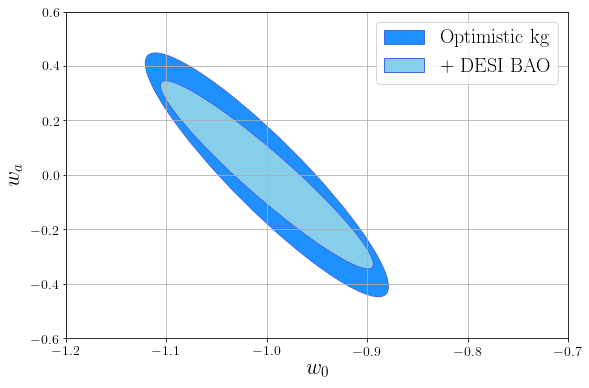

In [49]:
# Makee 2d contour plot

eigvec, eigval, u = np.linalg.svd(CovM)

# Semimajor axis (diameter)
semimaj = np.sqrt(eigval[0])*2.
# Semiminor axis (diameter)
semimin = np.sqrt(eigval[1])*2.

theta = np.arctan(eigvec[0][1]/eigvec[0][0])
   
# Plot 1-sig confidence region
ell = mpl.patches.Ellipse(xy=[-1,0], width=1.52*semimaj, height=1.52*semimin, angle = theta*180/np.pi, facecolor = 'dodgerblue', edgecolor = 'royalblue', label = 'Optimistic kg')
# Plot 2-sig confidence region
# ell2 = mpl.patches.Ellipse(xy=[-1,0], width=2.48*semimaj, height=2.48*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '95% confidence')

fig, ax = plt.subplots(figsize=(9,6.))

ax.add_patch(ell)

eigvec, eigval, u = np.linalg.svd(CovM2)

# Semimajor axis (diameter)
semimaj = np.sqrt(eigval[0])*2.
# Semiminor axis (diameter)
semimin = np.sqrt(eigval[1])*2.

theta = np.arctan(eigvec[0][1]/eigvec[0][0])
   
# Plot 1-sig confidence region
ell = mpl.patches.Ellipse(xy=[-1,0], width=1.52*semimaj, height=1.52*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '+ DESI BAO')
# Plot 2-sig confidence region
# ell2 = mpl.patches.Ellipse(xy=[-1,0], width=2.48*semimaj, height=2.48*semimin, angle = theta*180/np.pi, facecolor = 'skyblue', edgecolor = 'royalblue', label = '95% confidence')

ax.add_patch(ell)

# Set bounds for x,y axes
bounds = np.sqrt(CovM.diagonal())
plt.xlim(-1-4*bounds[0], -1+4*bounds[0])
plt.ylim(0-4*bounds[1], 0+4*bounds[1])

plt.grid(True)
plt.xlabel('$w_0$',fontsize = 22)
plt.ylabel('$w_a$',fontsize = 22)
plt.xlim(-1.2, -0.7)
plt.ylim(-0.6, 0.6)
plt.legend(fontsize = 20)
plt.show()